In [ ]:
import glob
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
from scipy.stats.mstats import gmean
import statistics; statistics.geometric_mean
from statsmodels.iolib.summary2 import summary_col
import yfinance as yf
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Returns found from WRDS
returns = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/returns.csv', index_col= None, header= 0)

In [ ]:
returns.head(20)

,PERMNO,date,CUSIP,PRC,VOL,RET
0,10000,1985-12-31,68391610,NaN,NaN,NaN
1,10000,1986-01-31,68391610,-4.37500,1771.0,C
2,10000,1986-02-28,68391610,-3.25000,828.0,-0.257143
3,10000,1986-03-31,68391610,-4.43750,1078.0,0.365385
4,10000,1986-04-30,68391610,-4.00000,957.0,-0.098592
5,10000,1986-05-30,68391610,-3.10938,1074.0,-0.222656
6,10000,1986-06-30,68391610,-3.09375,1069.0,-0.005025
7,10000,1986-07-31,68391610,-2.84375,1163.0,-0.080808
8,10000,1986-08-29,68391610,-1.09375,3049.0,-0.615385
9,10000,1986-09-30,68391610,-1.03125,3551.0,-0.057143


In [ ]:
returns['date']= pd.to_datetime(returns['date'], format='%Y-%m-%d')
returns['YEAR'] = pd.DatetimeIndex(returns['date']).year
returns['month'] = pd.DatetimeIndex(returns['date']).month
returns = returns[returns["YEAR"] >= 1985]
returns = returns.loc[(returns["PRC"] >= 0)] # we filter out stocks which are not liquid

In [ ]:
%%capture
returns['RET'] = returns['RET'].str.replace("[A-Z]","")
returns = returns[returns['RET'].astype(bool)]
returns['RET'] = returns['RET'].astype(float)

In [ ]:
returns1 = returns.groupby(['YEAR', 'PERMNO', 'CUSIP']).agg({'RET': lambda x: ((1+x).product() ** (12/float(len(x)))-1), 'PRC':'mean'}) # Annualize monthly returns
returns1 = returns1.reset_index()
returns1['yr1Ret'] = returns1['RET']
returns1 = returns1.loc[(returns1["PRC"] >= 5)] # we filter out stocks which are not liquid, we will take care of size and EP and BM later

In [ ]:
size = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/size_update.csv', index_col= None, header= 0)
size['DATE']= pd.to_datetime(size['DATE'], format='%m/%d/%Y')
size['YEAR'] = pd.DatetimeIndex(size['DATE']).year
size = size[size["YEAR"] >= 1985]
size = size.groupby(['PERMNO','YEAR']).permco_cap.mean()
size = size.to_frame().reset_index()
size = size.rename(columns = {'permco_cap':'SIZE'})

In [ ]:
df = pd.merge(returns1, size, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])
df = df.loc[(df['SIZE'] >= 10000)] #elminating stocks that are not liquid enough to trade
df['SIZE'] = np.log(df['SIZE']) # we will use log size as our factor

In [ ]:
mom = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/monthly/mom_fixed.csv', index_col= None, header= 0)
mom['DATE']= pd.to_datetime(mom['DATE'], format='%m/%d/%Y')
mom['YEAR'] = pd.DatetimeIndex(mom['DATE']).year
mom = mom[mom["YEAR"] >= 1985]
mom = mom.groupby(['PERMNO','YEAR']).cum_return.mean()
mom = mom.to_frame().reset_index()
mom = mom.rename(columns = {'cum_return':'mom'})

In [ ]:
df = pd.merge(df, mom, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
df

,YEAR,PERMNO,CUSIP,RET,PRC,yr1Ret,SIZE,mom
0,1985,10015,00016510,1.655737,7.052083,1.655737,10.162095,0.327061
1,1985,10057,00462610,-0.012118,14.885417,-0.012118,11.543515,-0.104138
2,1985,10137,01736110,0.254477,31.250000,0.254477,14.308213,0.247402
3,1985,10145,43851610,0.414333,42.625000,0.414333,15.083065,0.301853
4,1985,10146,00101510,0.098047,10.875000,0.098047,9.606361,-0.084062
...,...,...,...,...,...,...,...,...
93013,2017,93423,83001A10,0.159430,60.786667,0.159430,15.502143,0.135753
93014,2017,93426,92835K10,0.330688,20.125000,0.330688,12.259242,0.331405
93015,2017,93428,11133B40,0.330910,46.258333,0.330910,14.100809,0.095093
93016,2017,93429,12503M10,0.704509,96.920833,0.704509,16.148413,0.412987


In [ ]:
# vol = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/monthly/vol.csv', index_col= None, header= 0)
# vol['DATE']= pd.to_datetime(vol['DATE'], format='%m/%d/%Y')
# vol['YEAR'] = pd.DatetimeIndex(vol['DATE']).year
# vol = vol[vol["YEAR"] >= 1985]
# vol = vol.groupby(['PERMNO','YEAR'])._RMSE_.mean()
# vol = vol.to_frame().reset_index()
# vol = vol.rename(columns = {'_RMSE_':'vol'})

In [ ]:
# df = pd.merge(df, vol, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
# ltr = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/monthly/ltr_fixed.csv', index_col= None, header= 0)
# ltr['DATE']= pd.to_datetime(ltr['DATE'], format='%m/%d/%Y')
# ltr['YEAR'] = pd.DatetimeIndex(ltr['DATE']).year
# ltr = ltr[ltr["YEAR"] >= 1985]
# ltr = ltr.groupby(['PERMNO','YEAR']).cum_return.mean()
# ltr = ltr.to_frame().reset_index()
# ltr = ltr.rename(columns = {'cum_return':'ltr'})

In [ ]:
# df = pd.merge(df, ltr, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
# ci = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/monthly/ci_fixed.csv', index_col= None, header= 0)
# ci['DATE']= pd.to_datetime(ci['DATE'], format='%m/%d/%Y')
# ci['YEAR'] = pd.DatetimeIndex(ci['DATE']).year
# ci = ci[ci["YEAR"] >= 1985]
# ci = ci.groupby(['PERMNO','YEAR']).CI.mean()
# ci = ci.to_frame().reset_index()
# # ci = ci.rename(columns = {'cum_return':'ltr'})

In [ ]:
# df = pd.merge(df, ci, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
SG = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/quarterly/sg.csv', index_col= None, header= 0)
SG['DATE']= pd.to_datetime(SG['DATE'], format='%m/%d/%Y')
SG['YEAR'] = pd.DatetimeIndex(SG['DATE']).year
SG = SG[SG["YEAR"] >= 1985]
SG = SG.groupby(['PERMNO','YEAR']).SG.apply(lambda x: (1+x).product() ** (4/float(len(x))))
SG = SG.to_frame().reset_index()

<ipython-input-1202-e58cf1b4f7c3>:5: RuntimeWarning: invalid value encountered in double_scalars
  SG = SG.groupby(['PERMNO','YEAR']).SG.apply(lambda x: (1+x).product() ** (4/float(len(x))))


In [ ]:
df = pd.merge(df, SG, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
# Data beginning in 1985
df

,YEAR,PERMNO,CUSIP,RET,PRC,yr1Ret,SIZE,mom,SG
0,1985,10015,00016510,1.655737,7.052083,1.655737,10.162095,0.327061,29.629766
1,1985,10057,00462610,-0.012118,14.885417,-0.012118,11.543515,-0.104138,22.933622
2,1985,10137,01736110,0.254477,31.250000,0.254477,14.308213,0.247402,16.852261
3,1985,10145,43851610,0.414333,42.625000,0.414333,15.083065,0.301853,15.146641
4,1985,10146,00101510,0.098047,10.875000,0.098047,9.606361,-0.084062,19.095050
...,...,...,...,...,...,...,...,...,...
84033,2017,93423,83001A10,0.159430,60.786667,0.159430,15.502143,0.135753,16.711520
84034,2017,93426,92835K10,0.330688,20.125000,0.330688,12.259242,0.331405,16.105305
84035,2017,93428,11133B40,0.330910,46.258333,0.330910,14.100809,0.095093,21.624152
84036,2017,93429,12503M10,0.704509,96.920833,0.704509,16.148413,0.412987,54.250520


In [ ]:
target = "/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/"
files = glob.glob(target + "*.csv")
files

['/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/roe.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/ac_updated.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/dp_updated.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/ai_updated.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/ig.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/cp_update.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/ep_update.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/annual/ns.csv',
 '/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset p

In [ ]:
factors = pd.DataFrame()
for filename in files:
  raw = pd.read_csv(filename, index_col= None, header= 0)
  raw['DATE']= pd.to_datetime(raw['DATE'], format='%m/%d/%Y')
  raw['YEAR'] = pd.DatetimeIndex(raw['DATE']).year
 #raw['month'] = pd.DatetimeIndex(raw['DATE']).month                  # note that some factors are built so that years start and end in july
  raw = raw[raw["YEAR"] >= 1985]
  raw.set_index(['PERMNO', 'YEAR'], inplace=True)
  raw = raw.drop(columns=['DATE'])
  factors = pd.concat([factors, raw], axis=1,ignore_index=False)

factors = factors.rename(columns={"CI": "AI"})
factors.reset_index(inplace = True)

In [ ]:
df = pd.merge(df, factors, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
df.columns

Index(['YEAR', 'PERMNO', 'CUSIP', 'RET', 'PRC', 'yr1Ret', 'SIZE', 'mom', 'SG',
       'ROE', 'AC', 'DP', 'AI', 'IG', 'CP', 'EP', 'NS', 'AG', 'BM', 'IK',
       'LEV', 'OK', 'ROA', 'IA', 'NOA'],
      dtype='object')

In [ ]:
df1 = df.loc[df['BM'] > 0] # drop stocks with negative book value

In [ ]:
# Adding our factors

In [ ]:
roic = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/ROIC_final.csv', index_col= 0)

In [ ]:
roic = roic[roic["YEAR"] >= 1985]
roic = roic.groupby(['PERMNO','YEAR']).aftret_invcapx.mean()
roic = roic.to_frame().reset_index()
roic = roic.rename(columns = {'aftret_invcapx':'ROIC'})

In [ ]:
df1 = pd.merge(df1, roic, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
evm = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/ev_multiple_final.csv', index_col= 0)

In [ ]:
evm = evm[evm["YEAR"] >= 1985]
evm = evm.groupby(['PERMNO','YEAR']).evm.mean()
evm = evm.to_frame().reset_index()
# evm = roic.rename(columns = {'aftret_invcapx':'ROIC'})w

In [ ]:
df1 = pd.merge(df1, evm, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
inv_turnover = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/inv_turnover_final.csv', index_col= 0)

In [ ]:
inv_turnover = inv_turnover[inv_turnover["YEAR"] >= 1985]
inv_turnover = inv_turnover.groupby(['PERMNO','YEAR']).lninv_turn.mean()
inv_turnover = inv_turnover.to_frame().reset_index()

In [ ]:
df1 = pd.merge(df1, inv_turnover, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
cf_vol = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/cf_vol_final.csv', index_col= 0)

In [ ]:
cf_vol = cf_vol[cf_vol["YEAR"] >= 1985]
cf_vol = cf_vol.groupby(['PERMNO','YEAR']).cf_vol.mean()
cf_vol = cf_vol.to_frame().reset_index()

In [ ]:
df1 = pd.merge(df1, cf_vol, left_on = ['PERMNO','YEAR'] , right_on = ['PERMNO','YEAR'])

In [ ]:
df1.columns

Index(['YEAR', 'PERMNO', 'CUSIP', 'RET', 'PRC', 'yr1Ret', 'SIZE', 'mom', 'SG',
       'ROE', 'AC', 'DP', 'AI', 'IG', 'CP', 'EP', 'NS', 'AG', 'BM', 'IK',
       'LEV', 'OK', 'ROA', 'IA', 'NOA', 'ROIC', 'evm', 'lninv_turn', 'cf_vol'],
      dtype='object')

In [ ]:
df2 = df1.drop(columns = ['OK','AI','EP','CP']) # These factors were elminated due to constrains on the number of firms per year.

In [ ]:
df2 = df2.dropna()

In [ ]:
df2.columns

Index(['YEAR', 'PERMNO', 'CUSIP', 'RET', 'PRC', 'yr1Ret', 'SIZE', 'mom', 'SG',
       'ROE', 'AC', 'DP', 'IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA',
       'NOA', 'ROIC', 'evm', 'lninv_turn', 'cf_vol'],
      dtype='object')

In [ ]:
multivariate = df2[['yr1Ret','SIZE', 'mom', 'SG','ROE', 'AC', 'DP', 'IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA','NOA', 'ROIC', 'evm', 'lninv_turn', 'cf_vol']]

Text(0.5, 1.0, 'Correlation Heatmap')

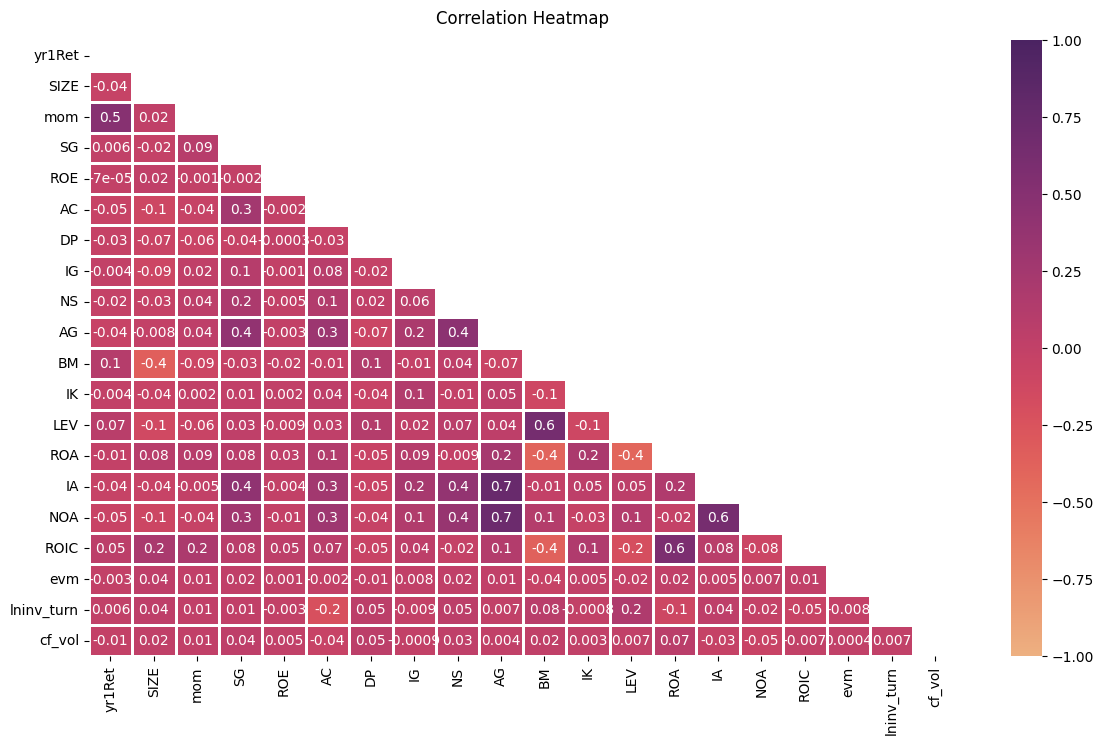

In [ ]:
# Correlation heatmap gives us insight into possible mulicolliniearity
mask = np.triu(np.ones_like(multivariate.corr(), dtype=bool))
plt.figure(figsize=(14,8))
heatmap = sns.heatmap(multivariate.corr(), mask = mask, vmin=-1, vmax=1, annot=True, fmt='.1g', cmap = "flare", linewidths=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
# removing outliers

In [ ]:
# function from lab exercises
def is_out(x):
    return abs(x - x.mean()) > x.std() * 3

In [ ]:
out = df2[['SIZE', 'mom', 'SG','ROE', 'AC', 'DP', 'IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA','NOA', 'ROIC', 'evm', 'lninv_turn', 'cf_vol']] # Explanatory Variables

#creating boolean df
outA = out.apply(is_out)

print('Total Outliers')
print(outA.apply(sum))
print('-------------')
# Next, create an index based on all columns of the Boolean index
outB = outA.any(axis = 1)

# Filter the columns removing the True values (outliers)
df3 = df2[~outB]

print("Before and After Shapes")
print(df2.shape)
print(df3.shape)

#reseting index
df3.reset_index(inplace = True, drop = True)

Total Outliers
SIZE           17
mom           270
SG            101
ROE             5
AC            419
DP             87
IG            155
NS            500
AG            354
BM            275
IK             24
LEV           363
ROA           350
IA            376
NOA           293
ROIC          344
evm            56
lninv_turn    335
cf_vol        203
dtype: int64
-------------
Before and After Shapes
(26074, 25)
(23054, 25)


In [ ]:
for i in df3['YEAR'].unique():
  n_firms = df3.loc[df3['YEAR'] == i, ['PERMNO']].nunique()[0]
  string = "For year {} we have {} unique firms"
  print(string.format(i, n_firms))

For year 1985 we have 1048 unique firms
For year 1986 we have 937 unique firms
For year 1987 we have 892 unique firms
For year 1988 we have 872 unique firms
For year 1989 we have 809 unique firms
For year 1990 we have 791 unique firms
For year 1991 we have 763 unique firms
For year 1992 we have 727 unique firms
For year 1993 we have 781 unique firms
For year 1994 we have 791 unique firms
For year 1995 we have 842 unique firms
For year 1996 we have 800 unique firms
For year 1997 we have 799 unique firms
For year 1998 we have 757 unique firms
For year 1999 we have 694 unique firms
For year 2000 we have 622 unique firms
For year 2001 we have 547 unique firms
For year 2002 we have 495 unique firms
For year 2003 we have 545 unique firms
For year 2004 we have 633 unique firms
For year 2005 we have 680 unique firms
For year 2006 we have 684 unique firms
For year 2007 we have 668 unique firms
For year 2008 we have 609 unique firms
For year 2009 we have 501 unique firms
For year 2010 we have 51

In [ ]:
returns5 = pd.read_csv('/content/drive/Shareddrives/BUFN736 - Group Project/Backtesting Project/final dataset part/Returns3.csv', index_col= None, header= 0)

In [ ]:
%%capture
returns5['PERMNO'] = returns5['LPERMNO']
company_dict = returns5[['sic','PERMNO','tic']]
company_dict['sic'] = company_dict['sic'].astype(str)
company_dict['sic_short'] = company_dict.sic.astype(str).str[:2].astype(int)
company_dict = company_dict.drop_duplicates()
company_dict = company_dict.dropna()

In [ ]:
df4 = pd.merge(df3, company_dict[['PERMNO','sic','sic_short','tic']], on='PERMNO') #Completely merged dataset with all kept factors

In [ ]:
df4

,YEAR,PERMNO,CUSIP,RET,PRC,yr1Ret,SIZE,mom,SG,ROE,...,ROA,IA,NOA,ROIC,evm,lninv_turn,cf_vol,sic,sic_short,tic
0,1985,10137,01736110,0.254477,31.250000,0.254477,14.308213,0.247402,16.852261,0.133940,...,0.057191,0.088068,0.836473,0.097182,6.231727,1.891061,0.007786,4911,49,AYE
1,1986,10137,01736110,0.426590,43.260417,0.426590,14.617939,0.455579,16.270911,0.144980,...,0.055077,0.118613,0.867692,0.099364,6.352636,2.001107,0.011572,4911,49,AYE
2,1987,10137,01736110,-0.096228,40.000000,-0.096228,14.528989,0.018435,15.627010,0.165051,...,0.055687,0.047091,0.820502,0.094182,6.322727,1.895782,0.013433,4911,49,AYE
3,1988,10137,01736110,0.089734,38.135417,0.089734,14.476567,0.030654,23.497132,0.095072,...,0.053704,0.064832,0.798738,0.093000,6.065727,2.066496,0.012930,4911,49,AYE
4,1989,10137,01736110,0.212866,38.770833,0.212866,14.499196,0.084872,17.093674,0.084802,...,0.051958,0.028467,0.767477,0.090818,6.243545,2.271528,0.006784,4911,49,AYE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23460,2017,89002,01858110,0.119089,239.397499,0.119089,16.475174,0.120023,20.674826,0.201455,...,0.019280,0.008411,0.909457,0.063182,16.556455,2.825773,0.014429,6141,61,BFH
23461,2017,91075,02916P10,-0.043125,39.939167,-0.043125,13.502055,0.003838,8.566439,0.127988,...,0.047487,0.053353,0.599290,0.061545,8.017636,1.516026,0.007853,3743,37,ARII
23462,2017,91594,84857410,0.504106,67.785000,0.504106,15.759792,0.376220,16.566435,0.244244,...,0.081298,-0.004812,0.401090,0.145364,7.994182,1.304858,0.020621,3728,37,SPR
23463,2017,91915,17243V10,-0.064052,38.833333,-0.064052,15.324685,0.110799,16.874792,0.178707,...,0.061818,0.090481,0.664999,0.111000,9.853182,4.917900,0.007595,7830,78,CNK


In [ ]:
df4.columns

Index(['YEAR', 'PERMNO', 'CUSIP', 'RET', 'PRC', 'yr1Ret', 'SIZE', 'mom', 'SG',
       'ROE', 'AC', 'DP', 'IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA',
       'NOA', 'ROIC', 'evm', 'lninv_turn', 'cf_vol', 'sic', 'sic_short',
       'tic'],
      dtype='object')

In [ ]:
df4 = df4.drop(columns = ['CUSIP','RET','PRC'])

In [ ]:
df4.columns

Index(['YEAR', 'PERMNO', 'yr1Ret', 'SIZE', 'mom', 'SG', 'ROE', 'AC', 'DP',
       'IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA', 'NOA', 'ROIC', 'evm',
       'lninv_turn', 'cf_vol', 'sic', 'sic_short', 'tic'],
      dtype='object')

In [ ]:
# Z-scores

In [ ]:
# Create industry specific z scores for all factors
explanatory = df4[['SIZE', 'mom', 'SG', 'ROE', 'AC', 'DP','IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA', 'NOA', 'ROIC', 'evm','lninv_turn', 'cf_vol']]
newcols = [i+'_Z' for i in explanatory]
df4[newcols] = explanatory.groupby(df4['sic_short']).apply(lambda x: (x - x.mean()) / x.std())

<ipython-input-1241-e4e44c67f9aa>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df4[newcols] = explanatory.groupby(df4['sic_short']).apply(lambda x: (x - x.mean()) / x.std())


In [ ]:
df4.columns

Index(['YEAR', 'PERMNO', 'yr1Ret', 'SIZE', 'mom', 'SG', 'ROE', 'AC', 'DP',
       'IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA', 'NOA', 'ROIC', 'evm',
       'lninv_turn', 'cf_vol', 'sic', 'sic_short', 'tic', 'SIZE_Z', 'mom_Z',
       'SG_Z', 'ROE_Z', 'AC_Z', 'DP_Z', 'IG_Z', 'NS_Z', 'AG_Z', 'BM_Z', 'IK_Z',
       'LEV_Z', 'ROA_Z', 'IA_Z', 'NOA_Z', 'ROIC_Z', 'evm_Z', 'lninv_turn_Z',
       'cf_vol_Z'],
      dtype='object')

In [ ]:
df5 = df4.drop(columns=['SIZE', 'mom', 'SG', 'ROE', 'AC', 'DP','IG', 'NS', 'AG', 'BM', 'IK', 'LEV', 'ROA', 'IA', 'NOA', 'ROIC', 'evm','lninv_turn', 'cf_vol', 'sic', 'sic_short', 'tic'])

In [ ]:
train = df5[df5['YEAR'] <= 2010]
test = df5[df5['YEAR'] > 2010] #Splitting training and testing samples by before and after 2010, respectively

In [ ]:
# Regression

In [ ]:
coefficients = pd.DataFrame()
for i in train['YEAR'].unique():
  results = smf.ols(formula = 'yr1Ret ~'+'+'.join(newcols), data = train[train['YEAR'] == i] ).fit()
  coeff = pd.DataFrame(results.params)
  coeff.columns = [i]
  coefficients = pd.concat([coefficients, coeff], axis = 1)

In [ ]:
coefficients.describe() #Descriptive statistics for each year

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2008,2009,2010,1999,2001,2004,2005,2006,2007,2003
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.016738,0.013843,0.011734,0.052120,0.020583,0.015308,0.029402,0.014738,0.015437,0.013092,...,-0.005986,0.050110,0.010999,0.022332,0.014299,0.012860,0.018745,0.020935,0.018091,0.038558
std,0.081714,0.049685,0.051168,0.123137,0.072283,0.047520,0.094565,0.050127,0.064240,0.047096,...,0.049839,0.126610,0.052592,0.096962,0.054010,0.050024,0.049076,0.066508,0.056162,0.113777
min,-0.079936,-0.027164,-0.032114,-0.041617,-0.060641,-0.031212,-0.060953,-0.021765,-0.052788,-0.027337,...,-0.174388,-0.065835,-0.046380,-0.079787,-0.053574,-0.021589,-0.019368,-0.033540,-0.025843,-0.027305
25%,-0.013522,-0.013206,-0.007277,-0.011551,-0.018609,-0.009602,-0.018670,-0.004789,-0.011392,-0.014848,...,-0.017123,-0.013031,-0.014498,-0.027006,-0.018867,-0.013591,-0.006553,-0.011454,-0.003100,-0.010213
50%,0.000494,0.003672,0.000327,0.000248,0.005117,0.003669,0.001486,-0.000429,-0.000377,-0.005711,...,-0.000718,0.010698,-0.001947,0.001378,-0.005114,-0.003275,0.004971,0.003407,0.005855,0.003113
75%,0.005892,0.017178,0.007807,0.038351,0.025525,0.016403,0.032033,0.007302,0.014393,0.028174,...,0.005000,0.060807,0.016154,0.020856,0.021008,0.013750,0.022911,0.010213,0.011239,0.021281
max,0.284371,0.203773,0.210714,0.413617,0.257560,0.191026,0.304649,0.191048,0.247291,0.163609,...,0.114820,0.517401,0.158207,0.332179,0.153939,0.192326,0.200989,0.225766,0.248101,0.440837


In [ ]:
# T-stat

In [ ]:
factor_premia = pd.DataFrame()
factor_premia['mean'] = coefficients.mean(axis=1)
factor_premia['std_dev'] = coefficients.std(axis=1)
t = len(pd.unique(df4['YEAR']))

for i in factor_premia.index:
  factor_premia['tvalues'] = (factor_premia['mean'] * np.sqrt(t))/factor_premia['std_dev']

In [ ]:
factor_premia #Identifying statistical significance and sign correctness

,mean,std_dev,tvalues
Intercept,0.160480,0.154019,5.985551
SIZE_Z,0.001519,0.037144,0.234917
mom_Z,0.215975,0.058012,21.386730
SG_Z,-0.009158,0.020306,-2.590914
ROE_Z,0.002000,0.029978,0.383211
AC_Z,-0.007976,0.018861,-2.429313
DP_Z,-0.009660,0.017088,-3.247413
IG_Z,-0.011333,0.018752,-3.471819
NS_Z,-0.005446,0.013956,-2.241628
AG_Z,-0.011698,0.021111,-3.183178


Factors Chosen:


*   mom
*   AC

*   IG

*   NS

*   AG

*   BM

*   ROIC
*   evm


*   cf_vol






In [ ]:
# Dropped factors with t-stats below 1.5 and/or with signs that were opposite of what was expected

In [ ]:
# %%capture
# test['score'] = test['mom_Z'] * factor_premia.loc['mom_Z','tvalues'] + test['ROE_Z'] * factor_premia.loc['ROE_Z','tvalues'] + test['AC_Z'] * factor_premia.loc['AC_Z','tvalues'] + test['IG_Z'] * factor_premia.loc['IG_Z','tvalues'] + test['NS_Z'] * factor_premia.loc['NS_Z','tvalues'] + test['AG_Z'] * factor_premia.loc['AG_Z','tvalues'] + test['BM_Z'] * factor_premia.loc['BM_Z','tvalues'] + test['ROIC_Z'] * factor_premia.loc['ROIC_Z','tvalues'] + test['cf_vol_Z'] * factor_premia.loc['cf_vol_Z','tvalues']

In [ ]:
# %%capture
# test['score'] = test['mom_Z'] * factor_premia.loc['mom_Z','tvalues'] + test['AC_Z'] * factor_premia.loc['AC_Z','tvalues'] + test['IG_Z'] * factor_premia.loc['IG_Z','tvalues'] + test['NS_Z'] * factor_premia.loc['NS_Z','tvalues'] + test['AG_Z'] * factor_premia.loc['AG_Z','tvalues'] + test['BM_Z'] * factor_premia.loc['BM_Z','tvalues'] + test['ROIC_Z'] * factor_premia.loc['ROIC_Z','tvalues'] + test['cf_vol_Z'] * factor_premia.loc['cf_vol_Z','tvalues']

In [ ]:
%%capture
test['score'] = test['mom_Z'] * factor_premia.loc['mom_Z','tvalues'] + test['AC_Z'] * factor_premia.loc['AC_Z','tvalues'] + test['IG_Z'] * factor_premia.loc['IG_Z','tvalues'] + test['NS_Z'] * factor_premia.loc['NS_Z','tvalues'] + test['AG_Z'] * factor_premia.loc['AG_Z','tvalues'] + test['BM_Z'] * factor_premia.loc['BM_Z','tvalues'] + test['ROIC_Z'] * factor_premia.loc['ROIC_Z','tvalues'] + test['evm_Z'] * factor_premia.loc['evm_Z','tvalues'] + test['cf_vol_Z'] * factor_premia.loc['cf_vol_Z','tvalues']

In [ ]:
%%capture
test['rank'] = test.groupby('YEAR')['score'].apply(lambda x: pd.qcut(x, 10, labels = False))

In [ ]:
long = test[test['rank'] == 9]
short = test[test['rank'] == 0]

In [ ]:
ret = pd.merge(returns[['PERMNO','YEAR','month','RET']], company_dict[['PERMNO','sic','sic_short','tic']], on='PERMNO')

In [ ]:
ret

,PERMNO,YEAR,month,RET,sic,sic_short,tic
0,10001,1986,9,-0.003077,4924,49,EGAS
1,10001,1986,10,0.039216,4924,49,EGAS
2,10001,1986,11,0.056604,4924,49,EGAS
3,10001,1986,12,0.015000,4924,49,EGAS
4,10001,1987,1,-0.035714,4924,49,EGAS
...,...,...,...,...,...,...,...
2733604,93436,2022,8,-0.072489,3711,37,TSLA
2733605,93436,2022,9,-0.037589,3711,37,TSLA
2733606,93436,2022,10,-0.142168,3711,37,TSLA
2733607,93436,2022,11,-0.144326,3711,37,TSLA


In [ ]:
li = []
for i in range(2009,2020):
  longRet = ret[(ret.PERMNO.isin(long[long.YEAR==i].PERMNO))&(ret.YEAR==i+1)]
  longRet = longRet.groupby(['YEAR','month']).RET.mean()
  longRet = longRet.reset_index()
  longRet.columns = ['YEAR','month','long']
  shortRet = ret[(ret.PERMNO.isin(short[short.YEAR==i].PERMNO))&(ret.YEAR==i+1)]
  shortRet = shortRet.groupby(['YEAR','month']).RET.mean()
  shortRet = shortRet.reset_index()
  shortRet.columns = ['YEAR','month','short']


  output = pd.merge(longRet, shortRet, left_on = ['YEAR','month'], right_on = ['YEAR','month'])
  li.append(output)

port = pd.concat(li, axis=0, ignore_index=True)
port['LS'] = port['long'] - port['short']

In [ ]:
port #Portfolio creation

,long,YEAR,month,short,LS
0,0.053008,2012,1,0.055741,-0.002733
1,0.045723,2012,2,-0.001029,0.046752
2,0.026560,2012,3,0.017549,0.009011
3,0.008984,2012,4,-0.013586,0.022570
4,-0.081594,2012,5,-0.047685,-0.033908
...,...,...,...,...,...
79,0.025146,2018,8,0.002828,0.022318
80,-0.024673,2018,9,-0.028162,0.003488
81,-0.088818,2018,10,-0.068197,-0.020621
82,-0.006021,2018,11,-0.009400,0.003379


In [ ]:
from pandas_datareader.famafrench import get_available_datasets
datasets = get_available_datasets()
print(datasets)

['F-F_Research_Data_Factors', 'F-F_Research_Data_Factors_weekly', 'F-F_Research_Data_Factors_daily', 'F-F_Research_Data_5_Factors_2x3', 'F-F_Research_Data_5_Factors_2x3_daily', 'Portfolios_Formed_on_ME', 'Portfolios_Formed_on_ME_Wout_Div', 'Portfolios_Formed_on_ME_Daily', 'Portfolios_Formed_on_BE-ME', 'Portfolios_Formed_on_BE-ME_Wout_Div', 'Portfolios_Formed_on_BE-ME_Daily', 'Portfolios_Formed_on_OP', 'Portfolios_Formed_on_OP_Wout_Div', 'Portfolios_Formed_on_OP_Daily', 'Portfolios_Formed_on_INV', 'Portfolios_Formed_on_INV_Wout_Div', 'Portfolios_Formed_on_INV_Daily', '6_Portfolios_2x3', '6_Portfolios_2x3_Wout_Div', '6_Portfolios_2x3_weekly', '6_Portfolios_2x3_daily', '25_Portfolios_5x5', '25_Portfolios_5x5_Wout_Div', '25_Portfolios_5x5_Daily', '100_Portfolios_10x10', '100_Portfolios_10x10_Wout_Div', '100_Portfolios_10x10_Daily', '6_Portfolios_ME_OP_2x3', '6_Portfolios_ME_OP_2x3_Wout_Div', '6_Portfolios_ME_OP_2x3_daily', '25_Portfolios_ME_OP_5x5', '25_Portfolios_ME_OP_5x5_Wout_Div', '25_

In [ ]:
import pandas_datareader.data as web
r = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=1985)[0]/100
r = r.reset_index()
r['Date'] = r['Date'].dt.to_timestamp(freq='M')
r['Date']= pd.to_datetime(r['Date'], format='%Y-%m')
r['YEAR'] = pd.DatetimeIndex(r['Date']).year
r['month'] = pd.DatetimeIndex(r['Date']).month
rf = r[['YEAR','month','RF','Mkt-RF','SMB','HML']]

In [ ]:
m = web.DataReader('F-F_Momentum_Factor', 'famafrench', start=1985)[0]/100

In [ ]:
m = m.reset_index()
m['Date'] = m['Date'].dt.to_timestamp(freq='M')
m['Date']= pd.to_datetime(m['Date'], format='%Y-%m')
m['YEAR'] = pd.DatetimeIndex(m['Date']).year
m['month'] = pd.DatetimeIndex(m['Date']).month
m['MOM'] = m['Mom   ']
m = m[['MOM','YEAR','month']]

In [ ]:
CA4 = pd.merge(m[['month', 'YEAR','MOM']], rf, left_on = ['month', 'YEAR'], right_on = ['month', 'YEAR'])

In [ ]:
portfolio = pd.merge(port, CA4, left_on = ['month', 'YEAR'], right_on = ['month', 'YEAR'])

In [ ]:
portfolio['long_excess_return'] = portfolio['long']-portfolio['RF']
portfolio['short_excess_return'] = portfolio['short']-portfolio['RF']
portfolio['LS_excess_return'] = portfolio['LS']-portfolio['RF']

In [ ]:
short_returns_mean = portfolio['short'].mean()
long_returns_mean = portfolio['long'].mean()
LS_returns_mean = portfolio['LS'].mean()
print(f'Short portfolio simple mean return is {short_returns_mean*100:.2f}%')
print(f'Long portfolio simple mean return is {long_returns_mean*100:.2f}%')
print(f'Long Short portfolio simple mean return is {LS_returns_mean*100:.2f}%')

Short portfolio simple mean return is 0.93%
Long portfolio simple mean return is 1.13%
Long Short portfolio simple mean return is 0.20%


In [ ]:
short_returns_geo = gmean(1+portfolio['short'])-1
long_returns_geo = gmean(1+portfolio['long'])-1
LS_returns_geo = gmean(1+portfolio['LS'])-1
print(f'Short portfolio geometric mean return is {short_returns_geo*100:.2f}%')
print(f'Long portfolio geometric mean return is {long_returns_geo*100:.2f}%')
print(f'Long Short portfolio geometric mean return is {LS_returns_geo*100:.2f}%')

Short portfolio geometric mean return is 0.84%
Long portfolio geometric mean return is 1.06%
Long Short portfolio geometric mean return is 0.16%


In [ ]:
portfolio_annual_long = portfolio[['long','YEAR','month']]
portfolio_annual_long = portfolio_annual_long.groupby(['YEAR']).agg({'long': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})
portfolio_annual_long1 = gmean(1+portfolio_annual_long['long'])-1
portfolio_annual_short = portfolio[['short','YEAR','month']]
portfolio_annual_short = portfolio_annual_short.groupby(['YEAR']).agg({'short': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})
portfolio_annual_short1 = gmean(1+portfolio_annual_short['short'])-1
portfolio_annual_ls = portfolio[['LS','YEAR','month']]
portfolio_annual_ls = portfolio_annual_ls.groupby(['YEAR']).agg({'LS': lambda x: ((1+x).product() ** (12/float(len(x)))-1)})
portfolio_annual_ls1 = gmean(1+portfolio_annual_ls['LS'])-1
print(f'Long portfolio annualized return is {portfolio_annual_long1*100:.2f}%')
print(f'Short portfolio annualized return is {portfolio_annual_short1*100:.2f}%')
print(f'Long short portfolio annualized return is {portfolio_annual_ls1*100:.2f}%')

Long portfolio annualized return is 13.44%
Short portfolio annualized return is 10.58%
Long short portfolio annualized return is 1.98%


In [ ]:
short_p2_sharpe = portfolio['short_excess_return'].mean() / portfolio['short_excess_return'].std()
short_p2_sharpe_annual = short_p2_sharpe * (12**0.5)
long_p2_sharpe = portfolio['long_excess_return'].mean() / portfolio['long_excess_return'].std()
long_p2_sharpe_annual = long_p2_sharpe * (12**0.5)
LS_p2_sharpe = portfolio['LS_excess_return'].mean() / portfolio['LS_excess_return'].std()
LS_p2_sharpe_annual = LS_p2_sharpe * (12**0.5)
print(f'Long portfolio annualized Sharpe ratio is {long_p2_sharpe_annual:.2f}')
print(f'Short portfolio annualized Sharpe ratio is {short_p2_sharpe_annual:.2f}')
print(f'Long short portfolio annualized Sharpe ratio is {LS_p2_sharpe_annual:.2f}')

Long portfolio annualized Sharpe ratio is 0.99
Short portfolio annualized Sharpe ratio is 0.72
Long short portfolio annualized Sharpe ratio is 0.22


In [ ]:
returns6 = pd.DataFrame()
returns6['Simple_Mean'] = portfolio[['long','short','LS']].mean()
returns6.loc['long','GeoMean'] = (gmean(1+portfolio['long'])-1)
returns6.loc['short','GeoMean'] = (gmean(1+portfolio['short'])-1)
returns6.loc['LS','GeoMean'] = (gmean(1+portfolio['LS'])-1)
returns6.loc['long','Sharpe'] = (portfolio['long_excess_return'].mean() / portfolio['long_excess_return'].std())*(12**0.5)
returns6.loc['short','Sharpe'] = (portfolio['short_excess_return'].mean() / portfolio['short_excess_return'].std())*(12**0.5)
returns6.loc['LS','Sharpe'] = (portfolio['LS_excess_return'].mean() / portfolio['LS_excess_return'].std())*(12**0.5)

In [ ]:
returns6 # Monthly

,Simple_Mean,GeoMean,Sharpe
long,0.011293,0.010566,0.986304
short,0.009335,0.008417,0.716745
LS,0.001958,0.001638,0.221945


In [ ]:
portfolio = portfolio.rename(columns={'Mkt-RF':'MKT'})

In [ ]:
CAPM1 = smf.ols(formula='LS ~ MKT', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1}) # I adjusted for autocorrelation because now this is a time series regression
FF31 = smf.ols(formula='LS ~ MKT + SMB + HML', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})
CH41 = smf.ols(formula='LS ~ MKT + SMB + HML + MOM', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})

In [ ]:
print(summary_col([CAPM1,FF31,CH41], model_names=['Long Short CAPM', 'Long Short FF3', 'Long Short CH4'],stars=True,regressor_order=['Intercept','MKT','SMB','HML','UMD']))


               Long Short CAPM Long Short FF3 Long Short CH4
------------------------------------------------------------
Intercept      0.0019          0.0009         -0.0002       
               (0.0025)        (0.0024)       (0.0026)      
MKT            0.0065          0.0643         0.1176        
               (0.1021)        (0.0925)       (0.0887)      
SMB                            -0.2855***     -0.2793***    
                               (0.1055)       (0.1020)      
HML                            -0.2976**      -0.1440       
                               (0.1216)       (0.1048)      
MOM                                           0.2346**      
                                              (0.1144)      
R-squared      0.0001          0.1574         0.2146        
R-squared Adj. -0.0121         0.1258         0.1748        
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
CAPM1 = smf.ols(formula='short ~ MKT', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1}) # I adjusted for autocorrelation because now this is a time series regression
FF31 = smf.ols(formula='short ~ MKT + SMB + HML', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})
CH41 = smf.ols(formula='short ~ MKT + SMB + HML + MOM', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})

In [ ]:
print(summary_col([CAPM1,FF31,CH41], model_names=['Short CAPM', 'Short FF3', 'Short CH4'],stars=True,regressor_order=['Intercept','MKT','SMB','HML','UMD']))


               Short CAPM Short FF3 Short CH4
---------------------------------------------
Intercept      -0.0014    0.0007    0.0016   
               (0.0025)   (0.0019)  (0.0020) 
MKT            1.0560***  0.9254*** 0.8816***
               (0.0962)   (0.0654)  (0.0621) 
SMB                       0.6485*** 0.6434***
                          (0.0815)  (0.0777) 
HML                       0.5153*** 0.3893***
                          (0.0913)  (0.0844) 
MOM                                 -0.1925**
                                    (0.0926) 
R-squared      0.6077     0.8230    0.8360   
R-squared Adj. 0.6029     0.8163    0.8277   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
CAPM1 = smf.ols(formula='long ~ MKT', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1}) # I adjusted for autocorrelation because now this is a time series regression
FF31 = smf.ols(formula='long ~ MKT + SMB + HML', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})
CH41 = smf.ols(formula='long ~ MKT + SMB + HML + MOM', data=portfolio).fit(cov_type='HAC',cov_kwds={'maxlags':1})

In [ ]:
print(summary_col([CAPM1,FF31,CH41], model_names=['Long CAPM', 'Long FF3', 'Long CH4'],stars=True,regressor_order=['Intercept','MKT','SMB','HML','UMD']))


               Long CAPM  Long FF3  Long CH4
--------------------------------------------
Intercept      0.0004    0.0016    0.0014   
               (0.0019)  (0.0017)  (0.0017) 
MKT            1.0624*** 0.9896*** 0.9992***
               (0.0506)  (0.0498)  (0.0498) 
SMB                      0.3630*** 0.3641***
                         (0.0659)  (0.0664) 
HML                      0.2177*** 0.2452***
                         (0.0592)  (0.0612) 
MOM                                0.0421   
                                   (0.0533) 
R-squared      0.7873    0.8587    0.8595   
R-squared Adj. 0.7847    0.8534    0.8524   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
